# 1. Import libraries


In [ ]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

# 2. Load Data

In [2]:
!labelme


[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\PC\.labelmerc


In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [62]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [63]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [64]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [65]:
def load_labels(label_path):
    with open(label_path.numpy(),'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['keypoints']]

In [66]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [67]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [68]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 2.3. Combine Labels and Images


In [69]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [70]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [71]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### 2.4 View Samples

In [72]:
data_samples = train.as_numpy_iterator()

In [76]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


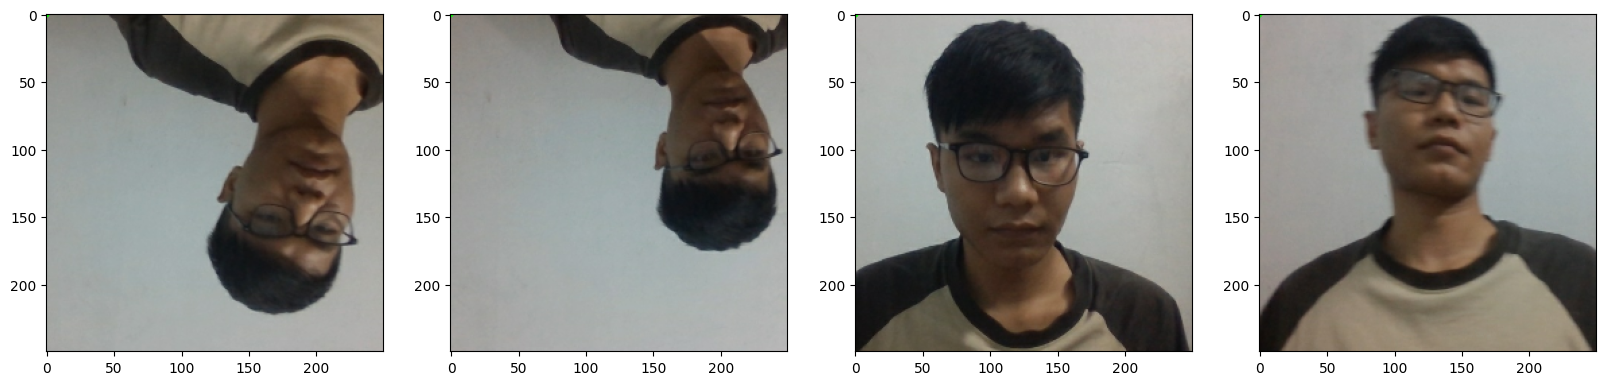

In [77]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

# 3. Build Model

### 3.1 Create Neural Network

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [79]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

234545216/234545216 [==============================] - 26s 0us/step


In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 3.2 Setup Losses and Optimizer

In [82]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

In [83]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [84]:
X, y = train.as_numpy_iterator().next()

In [85]:
X.shape

(16, 250, 250, 3)

In [86]:
scores = model.predict(X)

1/1 [==============================] - 15s 15s/step


In [87]:
scores

array([[ 0.13283539, -0.03755993,  0.15325318,  0.22677015],
       [ 0.57560366, -0.1392712 ,  0.3076172 , -0.33012837],
       [-0.04386005, -0.30272043,  0.41036224,  0.08004808],
       [-0.01399237, -0.54994065,  0.11703495,  0.02592656],
       [ 0.4247615 , -0.3342183 , -0.06972086,  0.41976663],
       [ 0.03351323, -0.23656085,  0.00792163, -0.06116274],
       [ 0.2226713 , -0.1414091 ,  0.22541164,  0.04982075],
       [ 0.38611144, -0.41910172,  0.3902989 ,  0.19769001],
       [ 0.31717902, -1.4017609 ,  0.31547165, -1.1994611 ],
       [ 0.76299584, -1.0863786 ,  0.72474277, -1.2822659 ],
       [ 1.0499101 , -0.7501242 , -0.6806857 , -0.5479048 ],
       [-0.13544033, -1.0033381 ,  0.76761997, -0.7144805 ],
       [ 0.7364018 , -0.47593468,  0.15218177, -1.084718  ],
       [ 0.22355202, -0.72381115,  0.08903727, -0.9442736 ],
       [ 0.9977463 , -1.3539425 ,  0.30848432, -1.8409202 ],
       [ 0.14447126, -0.5135652 , -0.08291793, -0.42867908]],
      dtype=float32)

### 3.4 Train the Model

In [ ]:
# Train for 100 epochs
hist = model.fit(train, epochs=3, validation_data=val)

# 4. Review Performance

### 4.1 View Loss Plots

hist.history

In [ ]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2. Make Predictions on Test

test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = model.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### 4.3. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('eyetrackerresnet.h5')

In [ ]:
model = load_model('eyetrackerresnet.h5')

In [ ]:
model.predict(test_sample[0])

# 5. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()